In [2]:
import xarray as xr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [3]:
temps = xr.open_dataset('TREFHTMN_TREFHTMX_71N156W_B20TRC5CNBDRD.f09_g16.002.cam.h1.19200101-21001231')

/Users/atocreu/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
dlopen(/Users/atocreu/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/rasterio/_base.cpython-38-darwin.so, 2): Symbol not found: _ZSTD_compressBound
  Referenced from: /Users/atocreu/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/rasterio/../../../libgdal.30.dylib
  Expected in: /Users/atocreu/opt/anaconda3/envs/pangeo/lib/libblosc.1.dylib
 in /Users/atocreu/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/rasterio/../../../libgdal.30.dylib
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
tmin = temps.TREFHTMN
tmax = temps.TREFHTMX

In [19]:
gs_min = tmin.groupby('time.dayofyear')
gs_max = tmax.groupby('time.dayofyear')

In [64]:
pre_ind_time_min = tmin.sel(time=slice(None, '1959-12-31'))
gs_pre_ind_time_min = pre_ind_time_min.groupby('time.dayofyear')
pre_ind_time_min, gs_pre_ind_time_min

(<xarray.DataArray 'TREFHTMN' (time: 14600)>
 array([240.92833, 239.55612, 241.26945, ..., 240.44469, 239.44731, 236.32397],
       dtype=float32)
 Coordinates:
     lon      float64 156.2
     lat      float64 71.15
   * time     (time) object 1920-01-01 00:00:00 ... 1959-12-31 00:00:00
 Attributes:
     units:         K
     long_name:     Minimum reference height temperature over output period
     cell_methods:  time: minimum,
 DataArrayGroupBy, grouped over 'dayofyear'
 365 groups with labels 1, 2, 3, 4, 5, ..., 362, 363, 364, 365.)

In [65]:
%%time
# 15 day rolling window for daily MIN temps 
min90_pct = []
# temp_placeholder_min = []

# start in spring (march 1)
for i in range(60,152): #windows -- center days
    temp_placeholder_min = []
    for key in range(i-7,i+8): #days in window
        values_min=gs_pre_ind_time_min[key]
        temp_placeholder_min.extend(values_min) #append entire list of years of day
    min90_pct.append(np.percentile(temp_placeholder_min, 90))
    

CPU times: user 14.9 s, sys: 120 ms, total: 15 s
Wall time: 15.2 s


In [66]:
spr_min=tmin.sel(time=tmin['time.season']=='MAM')

In [67]:
hwd=[] # the length (in days) of the longest yearly event
hwn=[] # yearly number of heat waves 
hwf=[] # sum of participating heat wave days per year 
for year in range(1920,2101):
    spryear = spr_min.sel(time=(spr['time.year']==year))
    above_90_pct_bool_list = spryear > min90_pct
    diffs = np.diff(above_90_pct_bool_list.astype(int))
    starts_in_loop = np.where(diffs==1)[0] # gives the indices where our starts are
    ends_in_loop = np.where(diffs==-1)[0]
    #missing end
    if len(starts_in_loop) > len(ends_in_loop):
        starts_in_loop = starts_in_loop[0:-1]
    #missing start
    elif len(ends_in_loop) > len(starts_in_loop):
        ends_in_loop = ends_in_loop[1:]
    #missing start and missing end
    elif ((ends_in_loop-starts_in_loop)<0).any():
        starts_in_loop = starts_in_loop[:-1]
        ends_in_loop =ends_in_loop[1:]
    num_consecutive_hot_days_in_loop = ends_in_loop-starts_in_loop
    if len(num_consecutive_hot_days_in_loop) == 0:
        num_consecutive_hot_days_in_loop = np.array([0])
    hwn.append(np.sum(num_consecutive_hot_days_in_loop>=3))
    heat_wave_durations = np.where(num_consecutive_hot_days_in_loop>=3, num_consecutive_hot_days_in_loop, 0)
    hwf.append(np.sum(heat_wave_durations))
    hwd.append(heat_wave_durations.max())

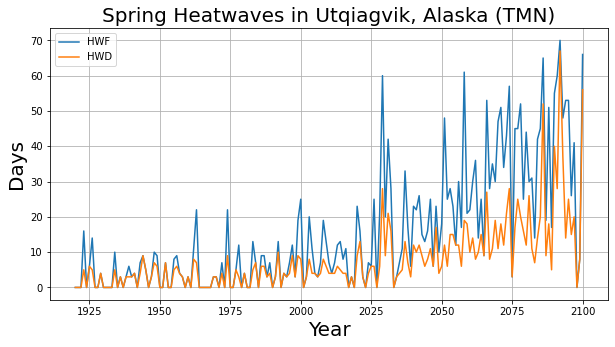

In [74]:
font = {'family': 'Sans',
        'color': 'black', 
        'weight': 'normal', 
        'size': 20,
       }
plt.figure(figsize=(10,5)) #what would be the obvious q, how would you address it?
#plt.plot(range(1920,2101),hwn, label='HWN') #blue
plt.plot(range(1920,2101),hwf, label='HWF') #orange
plt.plot(range(1920,2101),hwd, label='HWD') #green
#plt.plot(range(1920,2006),hwn_min, color='blue', label='HWN') 
plt.title('Spring Heatwaves in Utqiagvik, Alaska (TMN)', fontdict=font)
plt.xlabel('Year', fontdict=font)
plt.ylabel('Days', fontdict=font)
plt.grid()
plt.legend()
plt.savefig('HW_1920_2100_UT_MN.png', dpi=300, format='png')

In [60]:
#ut_min_fig.savefig('HW_1920_2100_UT_MN.png',dpi=300, format='png')

In [27]:
# plt.figure(figsize=(10,5)) #waht would be the obvious q, how would you address it?
# #plt.plot(range(1920,2006),hwn) #blue
# plt.plot(range(2006,2101),hwf, label='HWF') #orange
# plt.plot(range(2006,2101),hwd, label='HWD') #green
# #plt.plot(range(1920,2006),hwn_min, color='blue', label='HWN') 
# font = {'family': 'Sans',
#         'color': 'black', 
#         'weight': 'normal', 
#         'size': 12,
#        }
# plt.title('Predictions of Future Spring Heatwaves in Utqiagvik, Alaska', fontdict=font)
# plt.xlabel('Year', fontdict=font)
# plt.ylabel('Days', fontdict=font)
# plt.grid()
# plt.legend()
#plt.savefig('alert_spr_hw', file='jpeg');

## Max

In [76]:
pre_ind_time_max = tmax.sel(time=slice(None, '1959-12-31'))
gs_pre_ind_time_max = pre_ind_time_max.groupby('time.dayofyear')
pre_ind_time_max, gs_pre_ind_time_max

(<xarray.DataArray 'TREFHTMX' (time: 14600)>
 array([240.92833, 244.19266, 244.34935, ..., 247.63843, 240.60896, 239.3141 ],
       dtype=float32)
 Coordinates:
     lon      float64 156.2
     lat      float64 71.15
   * time     (time) object 1920-01-01 00:00:00 ... 1959-12-31 00:00:00
 Attributes:
     units:         K
     long_name:     Maximum reference height temperature over output period
     cell_methods:  time: maximum,
 DataArrayGroupBy, grouped over 'dayofyear'
 365 groups with labels 1, 2, 3, 4, 5, ..., 362, 363, 364, 365.)

In [77]:
spr_max=tmax.sel(time=tmax['time.season']=='MAM')

In [78]:
%%time
# 15 day rolling window for daily MAX temps
max90_pct = []

# start in spring (march 1)
for i in range(60,152):
    temp_placeholder_max = []
    for key in range(i-7,i+8):
        values_max=gs_pre_ind_time_max[key]
        temp_placeholder_max.extend(values_max)
    max90_pct.append(np.percentile(temp_placeholder_max, 90))

CPU times: user 16.3 s, sys: 175 ms, total: 16.5 s
Wall time: 17.3 s


In [79]:
hwd_max=[] # the length (in days) of the longest yearly event
hwn_max=[] # yearly number of heat waves 
hwf_max=[] # sum of participating heat wave days per year 
for year in range(1920,2101):
    spryear = spr_max.sel(time=(spr['time.year']==year))
    above_90_pct_bool_list_max = spryear > max90_pct
    diffs_max = np.diff(above_90_pct_bool_list_max.astype(int))
    starts_in_loop_max = np.where(diffs_max==1)[0] # gives the indices where our starts are
    ends_in_loop_max = np.where(diffs_max==-1)[0]
    #missing end
    if len(starts_in_loop_max) > len(ends_in_loop_max):
        starts_in_loop_max = starts_in_loop_max[0:-1]
    #missing start
    elif len(ends_in_loop_max) > len(starts_in_loop_max):
        ends_in_loop_max = ends_in_loop_max[1:]
    #missing start and missing end
    elif ((ends_in_loop_max-starts_in_loop_max)<0).any():
        starts_in_loop_max = starts_in_loop_max[:-1]
        ends_in_loop_max =ends_in_loop_max[1:]
    num_consecutive_hot_days_in_loop_max = ends_in_loop_max-starts_in_loop_max
    if len(num_consecutive_hot_days_in_loop_max) == 0:
        num_consecutive_hot_days_in_loop_max = np.array([0])
    hwn_max.append(np.sum(num_consecutive_hot_days_in_loop_max>=3))
    heat_wave_durations_max = np.where(num_consecutive_hot_days_in_loop_max>=3, num_consecutive_hot_days_in_loop_max, 0)
    hwf_max.append(np.sum(heat_wave_durations_max))
    hwd_max.append(heat_wave_durations_max.max())

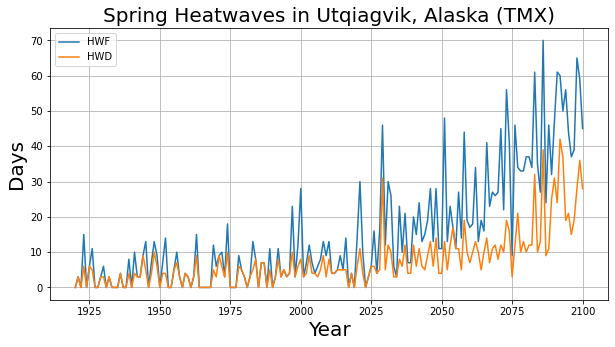

In [81]:
plt.figure(figsize=(10,5))
#plt.plot(range(1920,2101),hwn_max, label='HWN') 
plt.plot(range(1920,2101),hwf_max, label='HWF') 
plt.plot(range(1920,2101),hwd_max, label='HWD') 
font = {'family': 'Sans',
        'color': 'black', 
        'weight': 'normal', 
        'size': 20,
       }
plt.title('Spring Heatwaves in Utqiagvik, Alaska (TMX)', fontdict=font)
plt.xlabel('Year', fontdict=font)
plt.ylabel('Days', fontdict=font)
plt.grid()
plt.legend()
plt.savefig('HW_1920_2100_UT_MX.png', dpi=300, format='png')

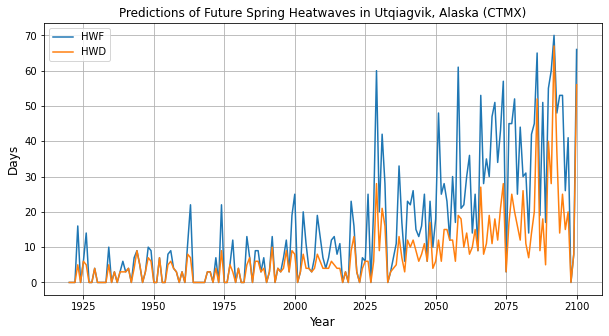

In [55]:
#test_figure

In [58]:
#test_figure.savefig('HW_1920_2100_UT_MX.png',dpi=300, format='png')

In [57]:
ls

ATOC4500_homework2_solutions.ipynb
Alert_heat_waves.ipynb
CESM1_MIN_X_TEMPS.ipynb
HW_1920_2100_UT
HW_1920_2100_UT.png
LICENSE
T90_spring2005.png
TREFHTMN_TREFHTMX_71N156W_B20TRC5CNBDRD.f09_g16.002.cam.h1 (1).19200101-20051231
TREFHTMN_TREFHTMX_71N156W_B20TRC5CNBDRD.f09_g16.002.cam.h1.19200101-21001231
TREFHTMN_TREFHTMX_82N62W_B20TRC5CNBDRD.f09_g16.002.cam.h1.19200101-20051231.nc
TREFHTMN_TREFHTMX_82N62W_B20TRC5CNBDRD.f09_g16.002.cam.h1.19200101-21001231
Untitled Folder/
Untitled.ipynb
Utqiagvik_heat_waves.ipynb
alert_hw_predictions.ipynb
alert_spr_hw.jpeg
alert_spr_hw.png
aravg.mon.land_ocean.60N.90N.v5.0.0.202112.asc
arctic_bigpicture.ipynb
reu_environment.yml
utqiagvik_hw_predictions.ipynb
utqiagvik_min_metrics.png
utqiagvik_spr_hw.png


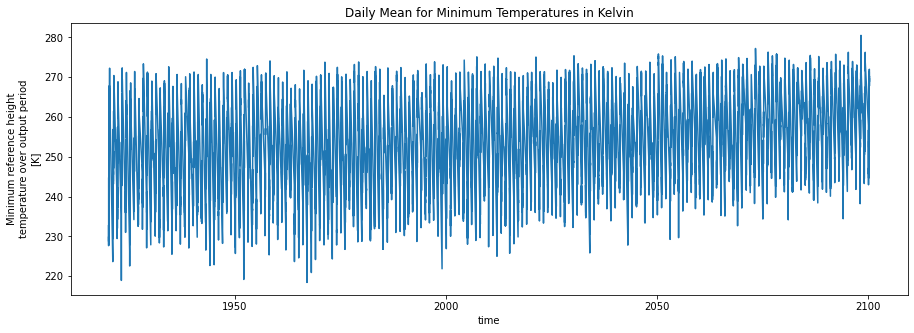

In [84]:
tminday_2100 = tmin.sel(time=tmin['time.season']=='MAM').plot(figsize=(15,5)) #blue
plt.title('Daily Mean for Minimum Temperatures in Kelvin');

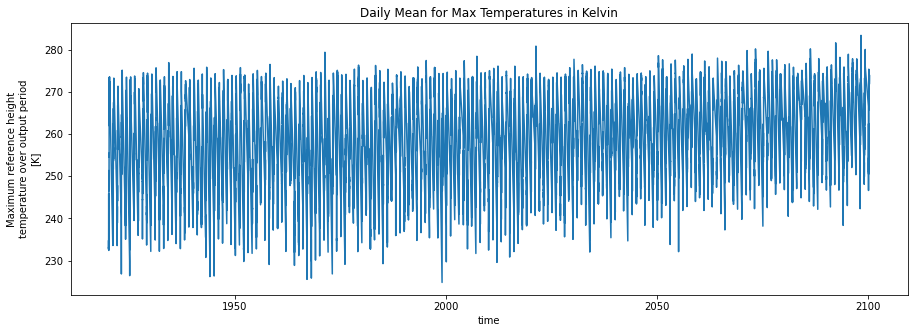

In [86]:
tmaxday_2100 = tmax.sel(time=tmax['time.season']=='MAM').plot(figsize=(15,5))
plt.title('Daily Mean for Max Temperatures in Kelvin');

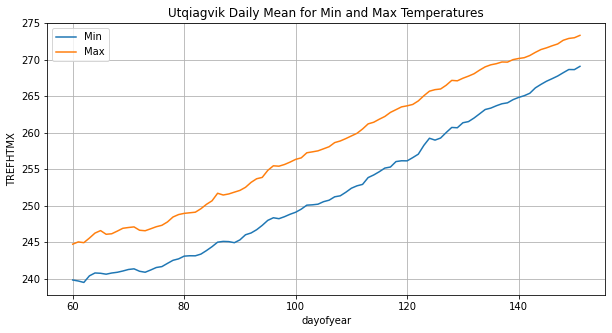

In [89]:
tmin.sel(time=tmin['time.season']=='MAM').groupby('time.dayofyear').mean(dim='time').plot(figsize=(10,5), label='Min')
tmax.sel(time=tmax['time.season']=='MAM').groupby('time.dayofyear').mean(dim='time').plot(label='Max')
plt.title('Utqiagvik Daily Mean for Min and Max Temperatures')
plt.grid()
plt.legend();

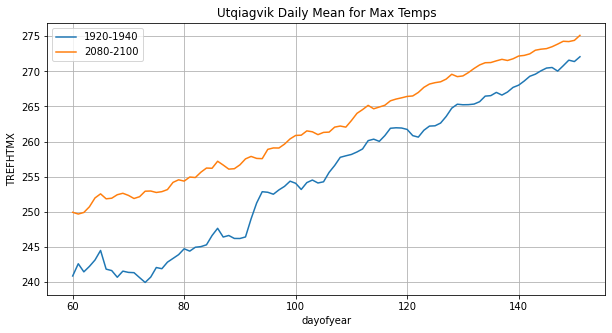

In [91]:
tmax.sel(time=tmax['time.season']=='MAM').sel(time=slice('1920-01-01', '1940-12-31')).groupby('time.dayofyear').mean(dim='time').plot(label='1920-1940', figsize=(10,5))
tmax.sel(time=tmax['time.season']=='MAM').sel(time=slice('2040-01-01', '2100-12-31')).groupby('time.dayofyear').mean(dim='time').plot(label='2080-2100')
plt.title('Utqiagvik Daily Mean for Max Temps')
plt.grid()
plt.legend();